### 載入所需的Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

### 載入資料

In [2]:
# read data from spam.csv

sms_data = pd.read_csv('spam.csv')
sms_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# check how many spams and hams
print(sms_data.groupby('v1').size())

v1
ham     4825
spam     747
dtype: int64


In [4]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1
sms_data['v1'] = sms_data['v1'].map({'spam': 1, 'ham': 0})
sms_data = sms_data.rename(columns={'v1': 'label'})
###<your code>###
sms_data.head()

,label,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,0,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,0,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,0,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### 切分資料
將資料依據label比例切分為training data與testing data

In [5]:
sms_data = sms_data.drop(sms_data.columns[[ 2, 3,4]], axis=1)
sms_train, sms_test = train_test_split(sms_data, test_size=0.2)

print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

         v2
label      
0      3868
1       589
        v2
label     
0      957
1      158


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [10]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(len(df)):
        # make all content to lowercase
        ###<your code>###

        # remove all punctuations
        ###<your code>###
        sentence = df['v2'].values[i]
        sentence = sentence.lower()

        #移除標點符號(可以依據使用狀況決定是否要移除標點符號)
        pattern = r'[a-zA-Z]+'
        sentence = re.findall(pattern, sentence)
        df.iloc[i,1] = " ".join(sentence)
        
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

/home/katnyeung/python_projects/python_env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Train:
      label                                                 v2
2255      0        i just lov this line hurt me with the truth
2211      0  just gettin a bit arty with my collages at the...
1325      0                yeah jay s sort of a fucking retard
3558      1  urgent we are trying to contact u todays draw ...
2947      0  nope but i ll b going sch on fri quite early l...
Test:
      label                                                 v2
413       0                            bring home some wendy d
1450      0                           msg me when rajini comes
2641      1  you are guaranteed the latest nokia phone a gb...
3538      0        what happen dear why you silent i am tensed
109       0                       dont worry i guess he s busy


In [11]:

# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

7708

### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [12]:
vectorizer = TfidfVectorizer(max_features=2000)
vectorizer.fit(list(x_train + x_test))
tfidf_train = vectorizer.transform(x_train)
tfidf_test= vectorizer.transform(x_test)
print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)


Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 50803 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 12835 stored elements in Compressed Sparse Row format>)

### 建立共現矩陣

In [13]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    vocab_size = len(vocab_list)
    co_matrix = np.zeros(shape=(vocab_size, vocab_size))
    
    for idx, sms in enumerate(corpus):
        sms = sms.split()
        sms_ids = [word2idx[word] for word in sms if word in vocab_list] #tokenize
        
        for center_i, center_word_id in enumerate(sms_ids):
            context_ids = sms_ids[max(0, center_i - window_size):center_word_id]
            content_len = len(context_ids)
            
            for left_i, left_word_id in enumerate(context_ids):
                if use_weighting:
                    distance = content_len - left_i
                    increment = 1./float(distance)
                else:
                    increment = 1
                co_matrix[center_word_id, left_word_id] += increment
                co_matrix[left_word_id, center_word_id] += increment
                
        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        np.fill_diagonal(co_matrix, 1.)
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### 建立PPMI矩陣

In [14]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

<ipython-input-14-a160d5082d4e>:11: RuntimeWarning: divide by zero encountered in log2
  pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))


array([[12.665759 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  3.5892673,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  7.2194552, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ..., 10.527114 ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  4.692409 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         6.739044 ]], dtype=float32)

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 10 and explained variance = 0.8659130189852158
Number of components = 20 and explained variance = 0.9019692429340243
Number of components = 30 and explained variance = 0.9194358694849286
Number of components = 40 and explained variance = 0.9312806265825093
Number of components = 50 and explained variance = 0.9399140468689827
Number of components = 60 and explained variance = 0.9468633560228541
Number of components = 70 and explained variance = 0.952538902137991
Number of components = 80 and explained variance = 0.9572120254281626
Number of components = 90 and explained variance = 0.9611062676575173
Number of components = 100 and explained variance = 0.964446867590747
Number of components = 110 and explained variance = 0.9673519945742518
Number of components = 120 and explained variance = 0.9699276058989141
Number of components = 130 and explained variance = 0.9721880221094975
Number of components = 140 and explained variance = 0.9741760914119696


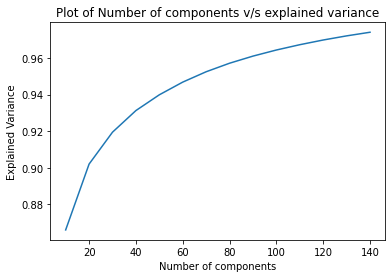

In [15]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    ###<your code>###
    svd = TruncatedSVD(n_components=dim)
    svd.fit(co_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
    print(f"Number of components = {dim} and explained variance = {svd.explained_variance_ratio_.sum()}")
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [16]:
# choose 140 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
svd = TruncatedSVD(n_components=140)
svd.fit(co_matrix)
re_co_matrix = svd.transform(co_matrix)

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [17]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 631 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 1033 doesn't contain word in vocab_list
k k congratulation


document 1223 doesn't contain word in vocab_list
beerage


document 1483 doesn't contain word in vocab_list
erutupalam thandiyachu


document 1839 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 1944 doesn't contain word in vocab_list
ringtoneking


document 2872 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli


document 2941 doesn't contain word in vocab_list
tf p


document 3036 doesn't contain word in vocab_list
g w r


document 3147 doesn't contain word in vocab_list



document 3483 doesn't contain word in vocab_list
east coast


document 3660 doesn't contain word in vocab_list
hanks lotsly


document 3711 doesn't contain word in vocab_list
audrie lousy autocorrect


document 3862 doesn't contain word in vocab_list
received understood n acted upon


docume

In [18]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(doc_vec_train, y_train_filter)
train_pred = knn.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
###<your code>###
test_pred = knn.predict(doc_vec_test)

In [19]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9725348941918055
train acc: 0.9568733153638814
